<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: старший преподаватель Факультета Компьютерных Наук ВШЭ, программист-исследователь Mail.ru Group  Юрий Кашницкий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 4. Обучение с учителем. Методы классификации
## <center>Часть 5. Проверка модели, недообучение, переобучение

In [24]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Валидация модели

Одним из важных этапов при использовании машинного обучения, является **валидация модели**: это, по своей сути, означает проверку того, насколько точно модель описывает имеющиеся данные, и как она будет работать с новыми данными (обощаться).

Рассмотрим все на примере цифр. Как понять, насколько точно наша модель описывает данные?

In [25]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

In [26]:
X.shape

(1797, 64)

Применим метод ближайших соседей

In [27]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

Теперь давайте с использованием этого классификатора сделаем прогнозирование для наших данных

In [28]:
y_pred = knn.predict(X)
print("{0} / {1} correct".format(np.sum(y == y_pred), len(y)))

1797 / 1797 correct


Похоже, мы получили прекрасный классификатор. Что тут не так?

## Выборка для валидации

Изначально ошибка была в том, что мы тестировали наш классификатор на данных, которые мы использовали для тренировки. **Это, в принципе, плохая идея**. Если мы будем продолжать в том же духе, наш классификатор **переобучится**, он будет плохо обобщаться, то есть плохо работать на новых данных.

Очевидно, необходимо использовать подвыборку отличную от той, которую мы используем для обучения модели. Воспользуемся встроенным разделением на train/test выборки:

In [29]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

((1347, 64), (450, 64))

Мы получили две подвыборки, одну для обучения, и вторую для валидации:

In [30]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

441 / 450 correct


Такой подход более точно отражает качество нашей модели.

Метрика, которая тут используется, отражает отношения количество правильно предсказанных значений, к общему числу наблюдений - **accuracy score**, можно очень легко посчитать, используя следующие методы:

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.97999999999999998

Можно и по-другому, используя метод ``model.score``:

In [32]:
knn.score(X_test, y_test)

0.97999999999999998

Используя такой подход, можно, меняя параметры модели, отслеживать качественные изменения:

In [33]:
for n_neighbors in [1, 5, 10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(n_neighbors, knn.score(X_test, y_test))

1 0.98
5 0.982222222222
10 0.98
20 0.971111111111
30 0.953333333333


Какой вывод можно сделать? Чем меньше соседей, тем лучше качество классификации (для этого набора данных).

## Кросс-валидация

Тем не менее, есть очевидный недостаток разделения всего на 2 подвыборки - мы, очевидно, теряем часть полезных данных. В примере выше мы использовали только 3/4 от всего количества данных, для обучения модели, и 1/4 для валидации. Есть другой способ **2-fold cross-validation**, делим выборку на 2 подвыборки, и 2 раза проводим валидацию:

In [34]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=0)
X1.shape, X2.shape

((898, 64), (899, 64))

In [35]:
print(KNeighborsClassifier(1).fit(X2, y2).score(X1, y1))
print(KNeighborsClassifier(1).fit(X1, y1).score(X2, y2))

0.983296213808
0.982202447164


Такой способ даст нам 2 возможных варианта модели.

Удобнее пользоваться встроенным методом **cross_val_score**:

In [36]:
from sklearn.cross_validation import cross_val_score
cv = cross_val_score(KNeighborsClassifier(1), X, y, cv=10)
cv.mean()

0.97614938602520218

### K-fold Cross-Validation

Мы использовали 2-fold cross-validation. Это частный случай $K$-fold cross-validation, где мы разделяем выборку на $K$ подвыборок и тренируем на $K$ подвыборках, где каждая используется для валидации.
Изменяя ``cv`` параметр, можно регулироват процесс. Давайте сделаем 10-fold cross-validation:

In [37]:
cross_val_score(KNeighborsClassifier(1), X, y, cv=10).mean()

0.97614938602520218

Такой подход дает лучшее представление о том, насколько наша модель хорошая.

Про выбор параметра K на форуме <a href="http://stats.stackexchange.com/questions/27730/choice-of-k-in-k-fold-cross-validation">Cross-Validated</a>, в <a href="http://ai.stanford.edu/~ang/papers/cv-final.pdf">статье</a> Andrew Ng и в <a href="http://robotics.stanford.edu/~ronnyk/accEst.pdf">статье</a> про выбор модели.

## Переобучение, недообучение и выбор модели

Теперь мы получили представление о валидации и кросс-валидации модели, рассмотрим возникающие проблемы более детально.

Все проблемы, указанные в заголовке, оказывают огромное влияние на применение машинного обучения для решения реальных задач. Выбор модели, наиболее точно отражающей реальный бизнесс-очень важен, но это часть, на которую не все в мире машинного обучения обращают внимание.

Главный вопрос:

**Если наше предсказание неточное, как нам его улучшить?**

- Сделать модель сложнее или упростить?
- Добавить больше признаков?
- Или нам просто нужно больше данных для обучения?

Ответы на данные вопросы не всегда лежат на поверхности.  В частности, иногда использование более сложной модели приведет к ухудшению показателей. Либо добавление наблюдений не приведет к ощутимым изменениям. Способность принять правильное решение и выбрать правильный способ улучшения модели, собственно говоря, и отличает хорошего специалиста от плохого.

### Пример

Очень простая регрессия.  Чтобы легче было себе все представлять и визуализировать будем использовать **linear regression** - `sklearn.linear_model`.

Создадим нелинейную функцию, для которой будем строить нашу регрессионную модель:

In [38]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

Данные:

In [39]:
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

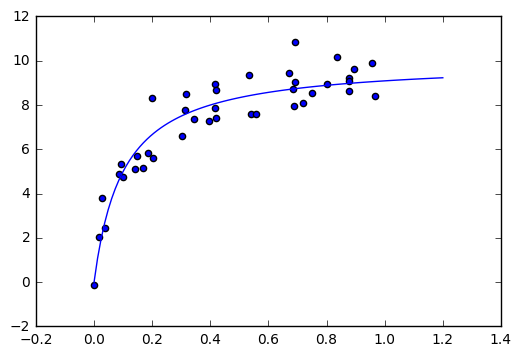

In [40]:
X, y = make_data(40, error=1)

def f(x):
    return 10 - 1. / (x + 0.1)
x = np.linspace(0, 1.2, 100)
real_y = [f(i) for i in x]
plot(x, real_y)
plt.scatter(X.ravel(), y);

Строим модель:

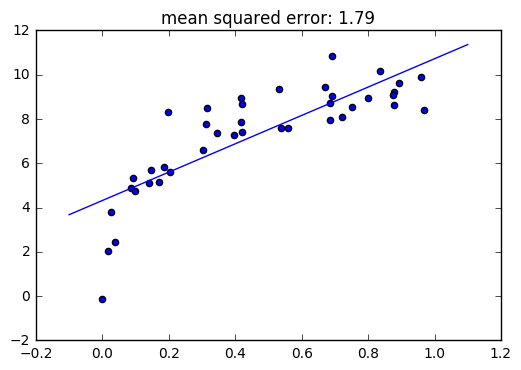

In [41]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}"
          .format(mean_squared_error(model.predict(X), y)));

Мы строим прямую, но это не самая хорошая идея для наших данных.  Можно сказать что модель **недообучилась** (high bias).

Давайте попробуем улучшить модель, усложнив ее.  Добавим немного степеней свободы нашей модели. В Scikit-learn это просто, с использованием ``PolynomialFeatures`` препроцессора, который можно ограничить линейной регрессией.

In [42]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Попробуем использовать квадратичные признаки

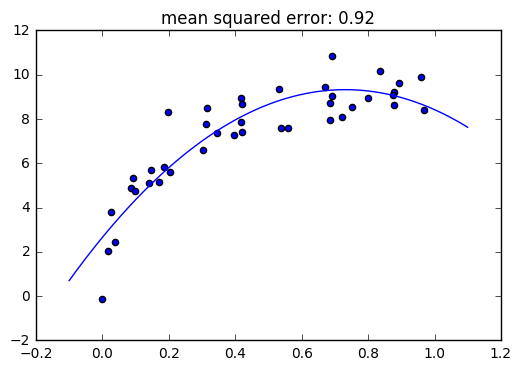

In [43]:
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}"
          .format(mean_squared_error(model.predict(X), y)));

Данное решение уменьшает средне-квадратичное отклонение и лучше соответствует нашим данным.  Давайте добавим степеней свободы, и посмотрим что произойдет

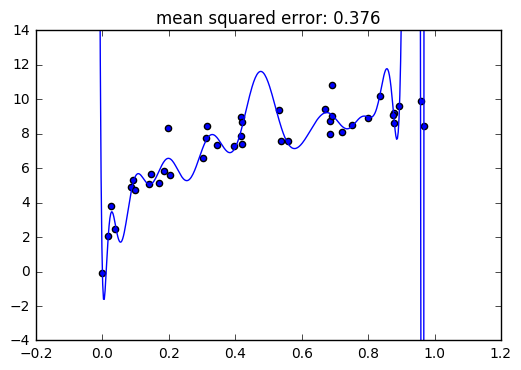

In [44]:
model = PolynomialRegression(30)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}"
          .format(mean_squared_error(model.predict(X), y)))
plt.ylim(-4, 14);

Когда мы увеличиваем число степеней свободы, мы видим, что кривая не описывает процесс в общем, но в 90% случаях четко проходит через точки обучающей выборки. В таком случае говорят, что модель **переобучилась** (**high variance**).

Давайте поиграем с параметрами модели, чтобы посмотреть как меняется форма нашей модели:

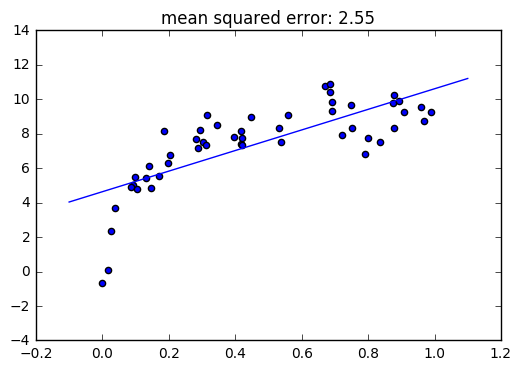

In [45]:
from IPython.html.widgets import interact

def plot_fit(degree=1, Npts=50):
    X, y = make_data(Npts, error=1)
    X_test = np.linspace(-0.1, 1.1, 500)[:, None]
    
    model = PolynomialRegression(degree=degree)
    model.fit(X, y)
    y_test = model.predict(X_test)

    plt.scatter(X.ravel(), y)
    plt.plot(X_test.ravel(), y_test)
    plt.ylim(-4, 14)
    plt.title("mean squared error: {0:.2f}".format(mean_squared_error(model.predict(X), y)))
    
interact(plot_fit, degree=[1, 30], Npts=[2, 100]);

### Как понять, что происходит?

Вычисления ошибки на тренировочной подвыборке недостаточно (как мы видели ранее). Попробуем применить **кросс-валидацию** чтобы получить более широкое представление об обобщающей способности модели.

Построим ``validation_curve``. Добавим данные в нашу выборку:

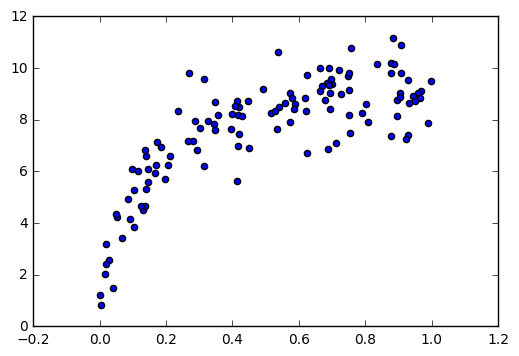

In [46]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [47]:
from sklearn.learning_curve import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(0, 10)
val_train, val_test = validation_curve(PolynomialRegression(), X, y,
                                       'polynomialfeatures__degree', 
                                       degree, cv=7,
                                       scoring=rms_error)

А теперь валидационные кривые:

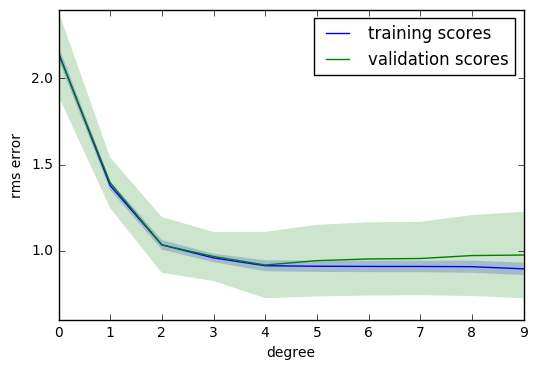

In [48]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend();

Тенденция видна сразу, и она очень часто встречается.

1. Для простых моделей тренировочная и валидационная ошибка находятся где-то рядом, и они велики. Это говорит о том, что модель **недообучилась**: то есть она не имеет достаточное кол-во параметров.

2. Для сильно усложненных моделей тренировочная и валидационная ошибки значительно отличаются. Это можно объяснить **переобучением** : когда параметров слишком много, алгоритм может "отвлекаться" на шум в данных и упускать основной тренд.

3. Также стоит отметить тренд снижения ошибки при усложнении модели. Это из-за шума, который может быть лучше отражен в сложной модели. В данном случае нужна модель с 5-ю степенями свооды, поскольку она показывает наименьшую ошибку при кросс-валидации.

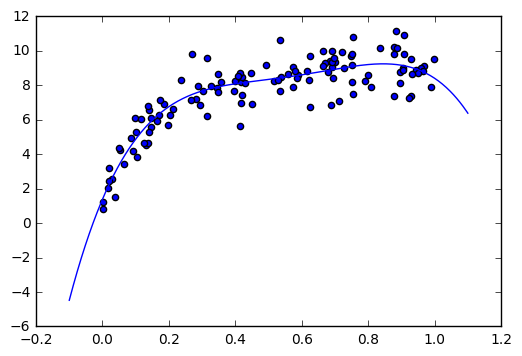

In [49]:
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test));

### Сколько нужно данных?

Поворотной точкой в поиске лучшей модели является момент, когда данных достаточно, но не больше.  Это можно изобразить, используя **кривые обучения** (**learning curves**).

Идея простая, мы отображаем ошибку как функцию от количества точек, используемых для обучения.

In [26]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(degree=3):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(PolynomialRegression(degree),
                                                  X, y, train_sizes, cv=5,
                                                  scoring=rms_error)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()

Давайте посмотрим, что мы получим для линейной модели:

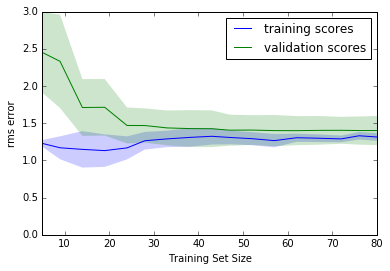

In [27]:
plot_learning_curve(degree=1)

Типичная ситуация: для небольшого объема данных ошибки на обучающей выборке и в процессе кросс-валидации довольно сильно отличаются, что указывает на **переобучение**.  Для той же модели, но с большим количеством точек ошибки "сходятся", что указывается на **недообучение**.

Если добавить еще данные, ошибка на обучающей выборке не будет расти, с другой стороны ошибка на тестовых данных не будет уменьшаться. 

Получается, ошибки "сошлись", и добавление новых данных не поможет. Что будет, если изменить $d$?

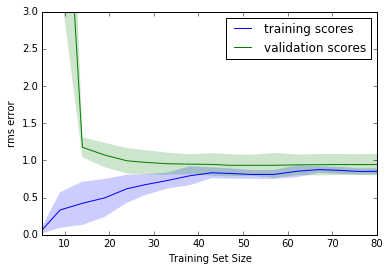

In [28]:
plot_learning_curve(4)

Если сложнять модель, можно получить значение обеих ошибок около 1.0!

А если усложнить ещё больше?

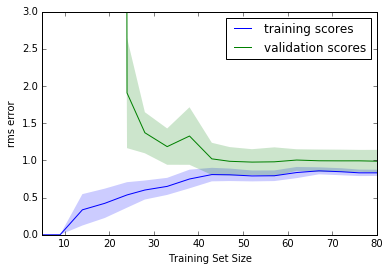

In [29]:
plot_learning_curve(10)

Кривые могут "сойтись", но на большой выборке.

Можно сделать следующие выводы:

- можно приближать валидационную ошибку к ошибке на обучающей выборке, добавляя наблюдения либо упрощая модель.
- обе ошибки можно уменьшить только усложняя модель.

Строя подобные кривые, можно понять, в какую сторону двигаться, и как найти суб-оптимальную модель.

## Выводы

- Ошибка на обучающей выборке сама по себе ничего не говорит о качестве модели
- Кросс-валидационная ошибка показывает, насколько хорошо модель подстраивается под данные (имеющийся тренд в данных), сохраняя при этом способность обобщения на новые данные
- **Валидационная кривая** представляют собой график, показывающий результат на тренировочной и валидационной выборке в зависимости от **сложности модели**:
  + если две кривые распологаются близко, и обе ошибки велики, -  это признак *недообучения*
  + если две кривые далеко друг от друга, - это показатель *переобучения*
- **Кривая обучения**  - это график, показывающий результаты на валидации и тренировочной подвыборке в зависимости от количества наблюдений. 
  + если кривые близко, добавление новых данных не поможет.
  + если кривые далеко, добавление новых данных может улучшить результат.